In [140]:
import os
from collections import defaultdict
from fuzzywuzzy import fuzz
import re
import pandas as pd

In [141]:
# List of reviewers
reviewers = [
    'achoreviews',
    'aftersound',
    'animagus',
    'arn',
    'bedrock',
    'bryaudioreviews',
    'cammyfi',
    'soundjedi',
    'eplv',
    'timmyv',
    'harpo',
    'hbb',
    'cqtek',
    'hobbytalk',
    'ianfann',
    'iemworld',
    'jacstone',
    'kr0mka',
    'kurin',
    'melatonin',
    'nymz', 
    'pw',
    'recode',
    'rg',
    'shortbus',
    'suporsalad',
    'tgx78',
    'vortexreviews',
    'vsg',
    'wdym',
    'akros',
    'data_mrs'
]

In [142]:
def remove_channel_suffix(file_name):
    file_name = file_name.lower()
    file_name = re.sub(r'\(.*?\)', '', file_name)  # Remove content in brackets
    file_name = file_name.strip()  # Remove leading and trailing spaces

    if " l.csv" in file_name:
        file_name = file_name.replace(" l.csv", ".csv")
    elif " r.csv" in file_name:
        file_name = file_name.replace(" r.csv", ".csv")

    return file_name.strip()  # Remove any extra spaces after channel suffix removal

In [143]:
def group_files_by_iem(files, threshold=100):
    groups = defaultdict(list)
    added_files = set()

    # Create a special "target" group
    target_group = "target"

    for file1 in files:
        modified_file1 = remove_channel_suffix(file1)

        # Check if the file name contains "target"
        if "target" in file1.lower():
            if file1 not in added_files:
                groups[target_group].append(file1)
                added_files.add(file1)
            continue

        if file1 not in added_files:
            groups[file1].append(file1)
            added_files.add(file1)

        for file2 in files:
            if file2 not in added_files:
                modified_file2 = remove_channel_suffix(file2)
                similarity = fuzz.token_set_ratio(modified_file1, modified_file2)

                # If the similarity score is above the threshold, add the file to the group
                if similarity >= threshold:
                    groups[file1].append(file2)
                    added_files.add(file2)
                # If the similarity score is between 95 and the threshold, compare only the IEM part
                elif 99 <= similarity < threshold:
                    iem1 = re.sub(r'[^a-zA-Z0-9]', '', modified_file1.split()[1]) if len(modified_file1.split()) > 1 else ''
                    iem2 = re.sub(r'[^a-zA-Z0-9]', '', modified_file2.split()[1]) if len(modified_file2.split()) > 1 else ''
                    iem_similarity = fuzz.token_set_ratio(iem1, iem2)
                    
                    if iem_similarity >= threshold:
                        groups[file1].append(file2)
                        added_files.add(file2)

    return groups

In [144]:
# Gather all file names
all_files = []

In [145]:
for reviewer in reviewers:
    reviewer_path = f'output/csv/{reviewer}'

    if os.path.exists(reviewer_path):
        files = os.listdir(reviewer_path)
        all_files.extend([(reviewer, file) for file in files])

In [146]:
# Group files by IEM
grouped_files = group_files_by_iem([file for _, file in all_files])

In [147]:
print(f"Total number of files: {len(all_files)}")
print(f"Total number of groups: {len(grouped_files)}")
print(f"Total number of files in groups: {sum([len(files) for files in grouped_files.values()])}")
print(f"Total number of files not in groups: {len(all_files) - sum([len(files) for files in grouped_files.values()])}")
print(f"\nAvg number of files per group: {sum([len(files) for files in grouped_files.values()]) / len(grouped_files)}")

Total number of files: 9882
Total number of groups: 2356
Total number of files in groups: 7668
Total number of files not in groups: 2214

Avg number of files per group: 3.2546689303904923


In [148]:
# Print grouped files
for representative, files in grouped_files.items():
    print(f"{representative}:")
    for file in files:
        reviewers_with_file = [reviewer for reviewer, f in all_files if f == file]
        print(f"  {file} - {', '.join(reviewers_with_file)}")
    print()

7Hz Dioko L.csv:
  7Hz Dioko L.csv - achoreviews, bedrock, timmyv, iemworld, data_mrs
  7HZ SALNOTES DIOKO L.csv - aftersound
  7HZ SALNOTES DIOKO R.csv - aftersound
  7Hz Salnotes Dioko L.csv - arn, pw
  7Hz Dioko R.csv - bedrock, timmyv, hbb, iemworld, data_mrs
  7hz Dioko L.csv - hobbytalk
  7hz Dioko R.csv - hobbytalk
  7HZ DIOKO (bass mod) L.csv - ianfann
  7HZ DIOKO (bass mod) R.csv - ianfann
  7HZ DIOKO L.csv - ianfann
  7HZ DIOKO R.csv - ianfann
  Dioko L.csv - kr0mka
  Dioko R.csv - kr0mka
  Resolve 7Hz Salnotes Dioko Gras L.csv - kurin
  7hz Salnotes Dioko L.csv - nymz
  7hz Salnotes Dioko R.csv - nymz
  7Hz Salnotes Dioko R.csv - pw
  7Hz Salnotes Dioko TapedVent L.csv - pw
  7hz x Crinacle Dioko L.csv - vortexreviews
  7hz x Crinacle Dioko R.csv - vortexreviews
  7hz x Crinacle Dioko Updated L.csv - vortexreviews
  7hz x Crinacle Dioko Updated R.csv - vortexreviews
  7Hz x Crinacle Salnotes Dioko L.csv - vsg
  7Hz x Crinacle Salnotes Dioko R.csv - vsg
  7Hz Dioko (post-op) 

### Dataframe

In [149]:
# Prepare the data for the DataFrame
iem_data = defaultdict(lambda: defaultdict(list))

for representative, files in grouped_files.items():
    for file in files:
        reviewers_with_file = [reviewer for reviewer, f in all_files if f == file]
        for reviewer in reviewers_with_file:
            iem_data[representative][reviewer].append(file)

# Convert the nested dictionary to a pandas DataFrame
iem_df = pd.DataFrame.from_dict(iem_data, orient='index')

# Fill empty cells with an empty list
iem_df = iem_df.applymap(lambda x: x if isinstance(x, list) else [])


In [150]:
iem_df

,achoreviews,bedrock,timmyv,iemworld,data_mrs,aftersound,arn,pw,hbb,hobbytalk,...,recode,animagus,bryaudioreviews,cammyfi,eplv,melatonin,shortbus,suporsalad,wdym,akros
7Hz Dioko L.csv,[7Hz Dioko L.csv],"[7Hz Dioko L.csv, 7Hz Dioko R.csv]","[7Hz Dioko L.csv, 7Hz Dioko R.csv]","[7Hz Dioko L.csv, 7Hz Dioko R.csv]","[7Hz Dioko L.csv, 7Hz Dioko R.csv, 7Hz Dioko (...","[7HZ SALNOTES DIOKO L.csv, 7HZ SALNOTES DIOKO ...",[7Hz Salnotes Dioko L.csv],"[7Hz Salnotes Dioko L.csv, 7Hz Salnotes Dioko ...",[7Hz Dioko R.csv],"[7hz Dioko L.csv, 7hz Dioko R.csv]",...,[],[],[],[],[],[],[],[],[],[]
7Hz Eternal L.csv,[7Hz Eternal L.csv],"[7Hz Eternal L.csv, 7Hz Eternal R.csv]",[],"[7Hz ETERNAL L.csv, 7Hz ETERNAL R.csv]",[],[],[],[],[7Hz Eternal R.csv],[],...,[],[],[],[],[],[],[],[],[],[]
7Hz Legato L.csv,[7Hz Legato L.csv],[],"[7Hz Legato L.csv, 7Hz Legato R.csv]",[],[],"[7HZ LEGATO L.csv, 7HZ LEGATO R.csv]",[],[],[7Hz Legato R.csv],[],...,[],[],[],[],[],[],[],[],[],[]
7Hz Timeless L.csv,[7Hz Timeless L.csv],[],"[7Hz Timeless L.csv, 7Hz Timeless R.csv, 7Hz T...","[7Hz Timeless (FINAL Tips) L.csv, 7Hz Timeless...","[7Hz Timeless L.csv, 7Hz Timeless R.csv, 7Hz T...","[7HZ TIMELESS AE L.csv, 7HZ TIMELESS AE R.csv,...",[7Hz Timeless L.csv],"[7Hz Timeless L.csv, 7Hz Timeless R.csv, 7Hz T...","[7Hz Timeless AE R.csv, 7Hz Timeless (no filte...","[7hz Timeless L.csv, 7hz Timeless R.csv, 7hz T...",...,[],[],[],[],[],[],[],[],[],[]
7Hz Zero L.csv,[7Hz Zero L.csv],"[7Hz Zero L.csv, 7Hz Zero R.csv]","[7Hz Zero L.csv, 7Hz Zero R.csv]","[7hz Zero (EJ07 FOAM Eartips) L.csv, 7hz Zero ...","[7Hz Zero L.csv, 7Hz Zero R.csv]","[7HZ SALNOTES ZERO L.csv, 7HZ SALNOTES ZERO R....",[7Hz Salnotes Zero L.csv],"[7Hz Salnotes Zero L.csv, 7Hz Salnotes Zero R....",[7hz Zero R.csv],"[7hz Zero R.csv, 7hz Zero L.csv, 7hz Zero Tape...",...,"[zero L.csv, zero R.csv]",[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"710 Btnc (Active, ANC off) L.csv",[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],"[710 Btnc (Active, ANC off) L.csv, 710 Btnc (A...",[]
Elegia (Stock Pads) L.csv,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[Elegia (Stock Pads) L.csv],[]
Elex (Dekoni Elite Fenestrated Sheepskin Pads) L.csv,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[Elex (Dekoni Elite Fenestrated Sheepskin Pads...,[]
Ola L.csv,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[Ola Stock L.csv]


### Average

### Target Adherence

In [151]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)

    if 'Y' not in df.columns:
        raise KeyError("Missing 'Y' column in the DataFrame")

    df = df.groupby('X', as_index=False).mean(numeric_only=True)

    min_x = max(df['X'].min(), 20)  # Start at 20Hz
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

def generate_x_values():
    x_values = np.logspace(np.log10(20), np.log10(20000), num=1000)
    return x_values

def find_mean_in_range(data, x_min, x_max):
    values = [df.loc[(df['X'] >= x_min) & (df['X'] <= x_max), 'Y'].dropna() for df in data]
    non_empty_values = [v for v in values if len(v) > 0]

    if not non_empty_values:
        return np.nan, 0

    combined_values = np.concatenate(non_empty_values)
    return np.nanmean(combined_values), len(combined_values)

def calculate_average(file_paths, output_path):
    x_values = generate_x_values()

    data = []
    for file_path in file_paths:
        try:
            interpolated_data = read_and_interpolate(file_path, x_values)
            interpolated_df = pd.DataFrame({'X': x_values, 'Y': interpolated_data})
            data.append(interpolated_df)
        except KeyError as e:
            print(f"KeyError in {file_path}: {e}. Skipping this file.")

    average = []
    measurements = []
    for x_min, x_max in zip(x_values[:-1], x_values[1:]):
        mean, num_measurements = find_mean_in_range(data, x_min, x_max)
        average.append(mean)
        measurements.append(num_measurements)

    df = pd.DataFrame({'X': x_values[:-1], 'Y': average})
    df.to_csv(output_path, index=False)

    return x_values, average, data, measurements

def calculate_iem_average(iem, reviewers_files, output_directory):
    file_paths = []
    for reviewer in reviewers_files.index:
        files = reviewers_files[reviewer]
        if files:
            for file in files:
                file_path = os.path.join('output/csv', reviewer, file).replace('\\', '/')
                file_paths.append(file_path)

    output_path = os.path.join(output_directory, f"Average_{iem}.csv")

    x_values, average, data, measurements = calculate_average(file_paths, output_path)
    return x_values, average, data, measurements


avg_df = pd.DataFrame(columns=['IEM', 'Average Measurement', 'Reviewers', '# of Measurements'])

output_directory = 'output/averages'
os.makedirs(output_directory, exist_ok=True)

for iem, reviewers_files in iem_df.iterrows():
    x_values, average, data, measurements = calculate_iem_average(iem, reviewers_files, output_directory)

    avg_df = pd.concat([avg_df, pd.DataFrame([{
        'IEM': iem.replace('L .csv', '').replace('R .csv', ''),
        'Average Measurement': os.path.join(output_directory, f"Average_{iem}.csv"),
        'Reviewers': {reviewer: files for reviewer, files in reviewers_files.items() if files},
        '# of Measurements': sum(measurements)
    }], index=[0])], ignore_index=True)



KeyError in output/csv/hbb/HBB 1 R.csv: 'Y'. Skipping this file.
KeyError in output/csv/vsg/Ugreen HiTune T3 L.csv: 'Y'. Skipping this file.


### Preference

In [152]:
avg_df

,IEM,Average Measurement,Reviewers,# of Measurements
0,7Hz Dioko L.csv,output/averages\Average_7Hz Dioko L.csv.csv,"{'achoreviews': ['7Hz Dioko L.csv'], 'bedrock'...",73759
1,7Hz Eternal L.csv,output/averages\Average_7Hz Eternal L.csv.csv,"{'achoreviews': ['7Hz Eternal L.csv'], 'bedroc...",21932
2,7Hz Legato L.csv,output/averages\Average_7Hz Legato L.csv.csv,"{'achoreviews': ['7Hz Legato L.csv'], 'timmyv'...",43850
3,7Hz Timeless L.csv,output/averages\Average_7Hz Timeless L.csv.csv,"{'achoreviews': ['7Hz Timeless L.csv'], 'timmy...",121655
4,7Hz Zero L.csv,output/averages\Average_7Hz Zero L.csv.csv,"{'achoreviews': ['7Hz Zero L.csv'], 'bedrock':...",93725
...,...,...,...,...
2351,"710 Btnc (Active, ANC off) L.csv","output/averages\Average_710 Btnc (Active, ANC ...","{'wdym': ['710 Btnc (Active, ANC off) L.csv', ...",5973
2352,Elegia (Stock Pads) L.csv,output/averages\Average_Elegia (Stock Pads) L....,{'wdym': ['Elegia (Stock Pads) L.csv']},1991
2353,Elex (Dekoni Elite Fenestrated Sheepskin Pads)...,output/averages\Average_Elex (Dekoni Elite Fen...,{'wdym': ['Elex (Dekoni Elite Fenestrated Shee...,7964
2354,Ola L.csv,output/averages\Average_Ola L.csv.csv,{'akros': ['Ola Stock L.csv']},1995


In [153]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [154]:
def generate_x_values():
    return np.logspace(np.log10(20), np.log10(20000), num=2000)

In [155]:
#def read_and_interpolate(file_path, x_values):
#    df = pd.read_csv(file_path)
#    min_x = df['X'].min()
#    max_x = df['X'].max()
#    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
#    f = interp1d(df['X'], pd.to_numeric(df['Y'], errors='coerce'), kind='linear', fill_value='extrapolate')
#    y_values = np.empty_like(x_values)
#    y_values[:] = np.nan
#    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
#    return y_values

In [156]:
def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    
    # Group data points by the same X-value and take the mean of their Y-values
    df = df.groupby('X', as_index=False).mean(numeric_only=True)

    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], pd.to_numeric(df['Y'], errors='coerce'), kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values


In [157]:
def find_mean_in_range(data, x_min, x_max, x_values):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

In [158]:
#def target_adherence(average_measurement, target_csv, x_values):
#    target_data = read_and_interpolate(target_csv, x_values)
#
#    alignment_freq_range = (200, 10000)  # frequency range for alignment
#
#    input_mean = find_mean_in_range(average_measurement, *alignment_freq_range, x_values)
#    target_mean = find_mean_in_range(target_data, *alignment_freq_range, x_values)
#
#    shift = target_mean - input_mean
#    average_measurement += shift
#
#    differences = np.abs(target_data - average_measurement)
#    
#    if np.any(np.isfinite(differences)):
#        mean_difference = np.nanmean(differences)
#    else:
#        mean_difference = 0  # or np.nan if you prefer
#
#    y_range = np.nanmax(target_data) - np.nanmin(target_data)
#
#    adherence = 100 * (1 - mean_difference / y_range)
#
#    return adherence

In [159]:
def target_adherence(average_measurement, target_csv, x_values):
    target_data = read_and_interpolate(target_csv, x_values)

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    input_mean = find_mean_in_range(average_measurement, *alignment_freq_range, x_values)
    target_mean = find_mean_in_range(target_data, *alignment_freq_range, x_values)

    shift = target_mean - input_mean
    average_measurement += shift

    differences = np.abs(target_data - average_measurement)

    if np.any(np.isfinite(differences)):
        mean_difference = np.nanmean(differences)
        stdev_difference = np.nanstd(differences)
    else:
        mean_difference = 0  # or np.nan if you prefer
        stdev_difference = 0  # or np.nan if you prefer

    finite_mask = np.isfinite(average_measurement) & np.isfinite(target_data)
    unique_mask = np.unique(average_measurement[finite_mask]).size > 1
    
    if unique_mask:
        slope, intercept, r_value, p_value, std_err = linregress(
            average_measurement[finite_mask], target_data[finite_mask]
        )
    else:
        slope = np.nan

    y_range = np.nanmax(target_data) - np.nanmin(target_data)

    adherence = 100 * (1 - mean_difference / y_range)

    return mean_difference, stdev_difference, slope, adherence


In [160]:
#def calculate_preference(row, target_csv, x_values):
#    average_measurement_file = row['Average Measurement']
#    average_measurement = read_and_interpolate(average_measurement_file, x_values)
#    return target_adherence(average_measurement, target_csv, x_values)


In [161]:
def calculate_preference(row, target_csv, x_values):
    average_measurement_file = row['Average Measurement']
    average_measurement = read_and_interpolate(average_measurement_file, x_values)
    return target_adherence(average_measurement, target_csv, x_values)


In [162]:
# Replace this with the path to your target curve CSV file
target_csv = 'Objectively Neutral IE Target.csv'

# Reuse the x_values generated earlier
x_values = generate_x_values()

## Calculate the Preference % for each IEM
#avg_df['Preference %'] = avg_df.apply(calculate_preference, axis=1, args=(target_csv, x_values))

In [163]:
avg_df[['Average Error', 'STDEV of Error', 'Slope of Error', 'Preference %']] = avg_df.apply(
    calculate_preference, axis=1, args=(target_csv, x_values), result_type="expand"
)


In [164]:
avg_df

,IEM,Average Measurement,Reviewers,# of Measurements,Average Error,STDEV of Error,Slope of Error,Preference %
0,7Hz Dioko L.csv,output/averages\Average_7Hz Dioko L.csv.csv,"{'achoreviews': ['7Hz Dioko L.csv'], 'bedrock'...",73759,1.717609,1.797850,0.941680,91.426219
1,7Hz Eternal L.csv,output/averages\Average_7Hz Eternal L.csv.csv,"{'achoreviews': ['7Hz Eternal L.csv'], 'bedroc...",21932,2.349936,3.339297,0.548229,88.269833
2,7Hz Legato L.csv,output/averages\Average_7Hz Legato L.csv.csv,"{'achoreviews': ['7Hz Legato L.csv'], 'timmyv'...",43850,3.807238,2.127075,0.561628,80.995426
3,7Hz Timeless L.csv,output/averages\Average_7Hz Timeless L.csv.csv,"{'achoreviews': ['7Hz Timeless L.csv'], 'timmy...",121655,1.694477,1.522492,0.883573,91.541688
4,7Hz Zero L.csv,output/averages\Average_7Hz Zero L.csv.csv,"{'achoreviews': ['7Hz Zero L.csv'], 'bedrock':...",93725,1.213503,1.304835,0.902699,93.942562
...,...,...,...,...,...,...,...,...
2351,"710 Btnc (Active, ANC off) L.csv","output/averages\Average_710 Btnc (Active, ANC ...","{'wdym': ['710 Btnc (Active, ANC off) L.csv', ...",5973,2.249154,2.276327,0.793888,88.772909
2352,Elegia (Stock Pads) L.csv,output/averages\Average_Elegia (Stock Pads) L....,{'wdym': ['Elegia (Stock Pads) L.csv']},1991,3.915132,3.476763,0.320431,80.456854
2353,Elex (Dekoni Elite Fenestrated Sheepskin Pads)...,output/averages\Average_Elex (Dekoni Elite Fen...,{'wdym': ['Elex (Dekoni Elite Fenestrated Shee...,7964,3.567687,3.468360,0.447101,82.191195
2354,Ola L.csv,output/averages\Average_Ola L.csv.csv,{'akros': ['Ola Stock L.csv']},1995,3.249254,3.475750,0.538224,83.780715


In [165]:
sorted_df = avg_df.sort_values(by='Preference %', ascending=False)

In [166]:
sorted_df

,IEM,Average Measurement,Reviewers,# of Measurements,Average Error,STDEV of Error,Slope of Error,Preference %
1041,HBB 1 R.csv,output/averages\Average_HBB 1 R.csv.csv,{'hbb': ['HBB 1 R.csv']},0,0.000000,0.000000,NaN,100.000000
2308,Not 02 L.csv,output/averages\Average_Not 02 L.csv.csv,{'shortbus': ['Not 02 L.csv']},376,0.000000,0.000000,NaN,100.000000
2338,DF Tilt 711 Ref.csv,output/averages\Average_DF Tilt 711 Ref.csv.csv,{'suporsalad': ['DF Tilt 711 Ref.csv']},1997,0.693946,0.687152,0.994573,96.536035
286,Thieaudio Clair L.csv,output/averages\Average_Thieaudio Clair L.csv.csv,"{'timmyv': ['Thieaudio Clair L.csv', 'Thieaudi...",7974,0.862134,1.233884,0.970781,95.696491
1549,Resolve Pixel Buds Pro Gras L.csv,output/averages\Average_Resolve Pixel Buds Pro...,{'kurin': ['Resolve Pixel Buds Pro Gras L.csv']},1988,0.877197,0.960423,0.929202,95.621301
...,...,...,...,...,...,...,...,...
1709,UA Complimentary 2 L.csv,output/averages\Average_UA Complimentary 2 L.c...,"{'vsg': ['UA Complimentary 2 L.csv', 'UA Compl...",3990,14.303533,9.262241,-0.091403,28.601125
2339,Electra Earbuds L.csv,output/averages\Average_Electra Earbuds L.csv.csv,{'suporsalad': ['Electra Earbuds L.csv']},1998,14.387920,9.401361,-0.112283,28.179890
2334,Air Canada Earphones L.csv,output/averages\Average_Air Canada Earphones L...,"{'suporsalad': ['Air Canada Earphones L.csv', ...",3984,15.588230,13.134251,-0.080396,22.188308
1708,UA Complimentary 1 L.csv,output/averages\Average_UA Complimentary 1 L.c...,"{'vsg': ['UA Complimentary 1 L.csv', 'UA Compl...",3990,15.966829,9.803782,-0.080386,20.298459


### Plot Top 10

In [167]:
#def plot_preference(input_csv, target_csv, adherence_percentage, colors, reviewers, avg_error, stdev_error, slope_error):
#    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)
#
#    input_data = read_and_interpolate(input_csv, x_values)
#    target_data = read_and_interpolate(target_csv, x_values)
#
#    alignment_freq_range = (200, 10000)  # frequency range for alignment
#    input_mean = find_mean_in_range(input_data, *alignment_freq_range, x_values)
#    target_mean = find_mean_in_range(target_data, *alignment_freq_range, x_values)
#
#    shift = target_mean - input_mean
#    input_data += shift
#
#    plt.figure(figsize=(20, 10))
#
#    plt.ylim(30, 85)
#    plt.xlim(20, 20000)
#
#    # Plot input data (colored line)
#    plt.plot(x_values, input_data, color=colors, linewidth=2, label='Input')
#
#    # Plot target data (dotted line)
#    plt.plot(x_values, target_data, color='gray', linestyle='--', linewidth=2, label='Target')
#
#    # Color the areas where the input plot deviates from the target plot
#    plt.fill_between(x_values, input_data, target_data, where=(input_data > target_data), facecolor='pink', alpha=0.5)
#    plt.fill_between(x_values, input_data, target_data, where=(input_data < target_data), facecolor='pink', alpha=0.5)
#
#    plt.xscale('log')
#    plt.xlabel('Frequency (Hz)')
#    plt.ylabel('dB')
#    reviewers_vertical = '\n'.join([f'{key}: {value}' for key, value in reviewers.items()])
#    title_text = (f'Preference Plot - Adherence: {adherence_percentage:.2f}%\n'
#                  f'Reviewers:\n{reviewers_vertical}\n'
#                  f'Average Error: {avg_error:.2f} dB | '
#                  f'Standard Deviation of Error: {stdev_error:.2f} dB | '
#                  f'Slope of Error: {slope_error:.2f}')
#    plt.title(title_text)
#    plt.legend()
#
#    # Customize X-axis
#    x_ticks = np.array([
#        20, 30, 40, 50, 60, 80, 100, 150,
#        200, 300, 400, 500, 600, 800,
#        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
#        10000, 15000, 20000
#    ])
#    labels = [
#        f'{int(x)}Hz' if x == 20
#        else f'{int(x)}' if x < 1000
#        else f'{x/1000:.1f}k' if x == 1500
#        else f'{x//1000:.0f}k' if x != 20000
#        else '20kHz' for x in x_ticks
#    ]
#    plt.xticks(x_ticks, labels=labels, fontsize=12)
#
#    plt.grid(True, which='both', linestyle='--', alpha=0.5)
#    plt.show()

In [168]:
def clean_iem_name(iem_name):
    # Add logic to clean iem_name here
    clean_name = iem_name.replace('_', ' ')
    return clean_name



In [169]:
def moving_average(data, window_size=3):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

In [170]:
def find_mean_in_range(data, x_values, min_freq, max_freq):
    data_in_range = data[(x_values >= min_freq) & (x_values <= max_freq)]
    if len(data_in_range) == 0:
        return np.nan
    return np.mean(data_in_range)

In [171]:
def plot_preference(input_csv, target_csv, adherence_percentage, colors, reviewers, avg_error, stdev_error, slope_error):
    x_values = np.logspace(np.log10(20), np.log10(20000), num=2000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    # Apply moving average filter to input_data and target_data
    input_data = moving_average(input_data)
    target_data = moving_average(target_data)

    # Smooth the data at 20Hz and 20kHz
    input_data[0], input_data[-1] = (input_data[1] + input_data[2]) / 2, (input_data[-2] + input_data[-3]) / 2
    target_data[0], target_data[-1] = (target_data[1] + target_data[2]) / 2, (target_data[-2] + target_data[-3]) / 2

    alignment_freq_range = (200, 10000)  # frequency range for alignment
    input_mean = find_mean_in_range(input_data, x_values, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, x_values, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    plt.figure(figsize=(20, 10))
    
    plt.ylim(30, 85)
    plt.xlim(20, 20000)

    # Plot input data (colored line)
    plt.plot(x_values, input_data, color=colors, linewidth=2, label='Input')

    # Plot target data (dotted line)
    plt.plot(x_values, target_data, color='gray', linestyle='--', linewidth=2, label='Target')

    # Color the areas where the input plot deviates from the target plot
    plt.fill_between(x_values, input_data, target_data, where=(input_data > target_data), facecolor='pink', alpha=0.5)
    plt.fill_between(x_values, input_data, target_data, where=(input_data < target_data), facecolor='pink', alpha=0.5)

    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('dB')

    # Clean reviewer names
    reviewers_vertical = '\n'.join([f'{key}' for key, value in reviewers.items()])

    # Extract IEM name from input_csv file path
    iem_name, _ = os.path.splitext(os.path.basename(input_csv))

    # Clean IEM name
    cleaned_iem_name = clean_iem_name(iem_name)

    title_text = (f'{cleaned_iem_name} - Adherence: {adherence_percentage:.2f}%\n'
                  f'Avg Err: {avg_error:.3f}; StDev Err: {stdev_error:.3f}; Slope Err: {slope_error:.3f}')
    
    plt.title(title_text, fontsize=14, fontweight='bold')

    plt.legend()

    # Add reviewers' names inside the plot
    plt.text(25, 62, f"Reviewer(s):\n{reviewers_vertical}", fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', pad=5, alpha=0.8))

    # Customize X-axis
    x_ticks = np.array([
        20, 30, 40, 50, 60, 80, 100, 150,
        200, 300, 400, 500, 600, 800,
        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
        10000, 15000, 20000
    ])
    
    labels = [
        f'{int(x)}Hz' if x == 20
        else f'{int(x)}' if x < 1000
        else f'{x/1000:.1f}k' if x == 1500
        else f'{x//1000:.0f}k' if x != 20000
        else '20kHz' for x in x_ticks
    ]
    
    plt.xticks(x_ticks, labels=labels, fontsize=12)
    plt.yticks(np.arange(30, 85, 5))

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

Plotting DF Tilt 711 Ref.csv with Preference %: 96.54%


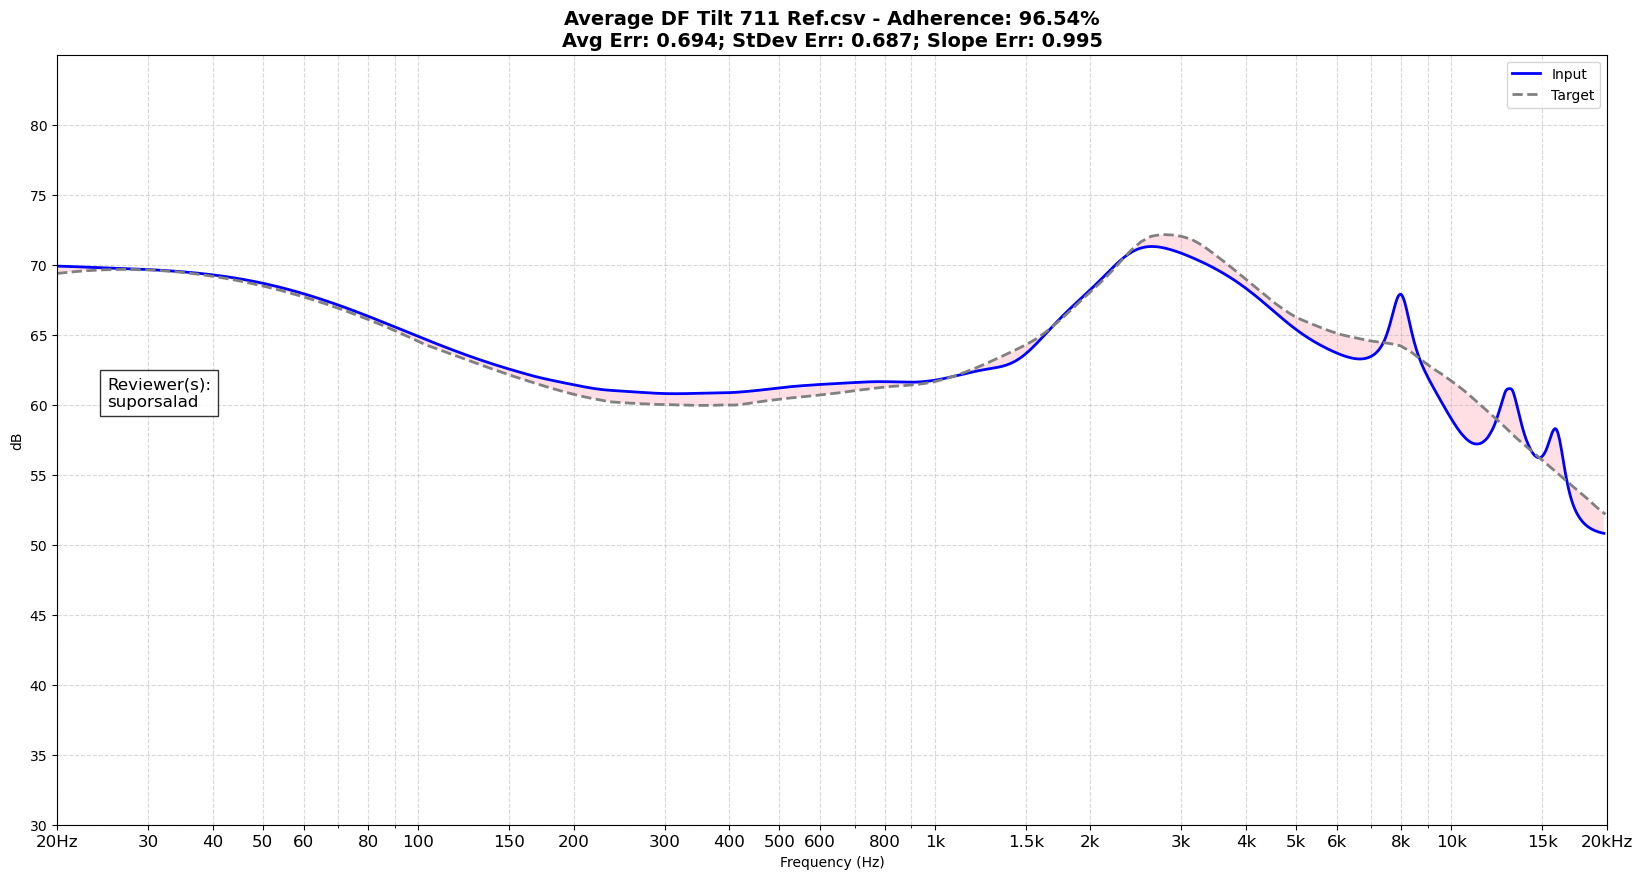

Plotting Thieaudio Clair L.csv with Preference %: 95.70%


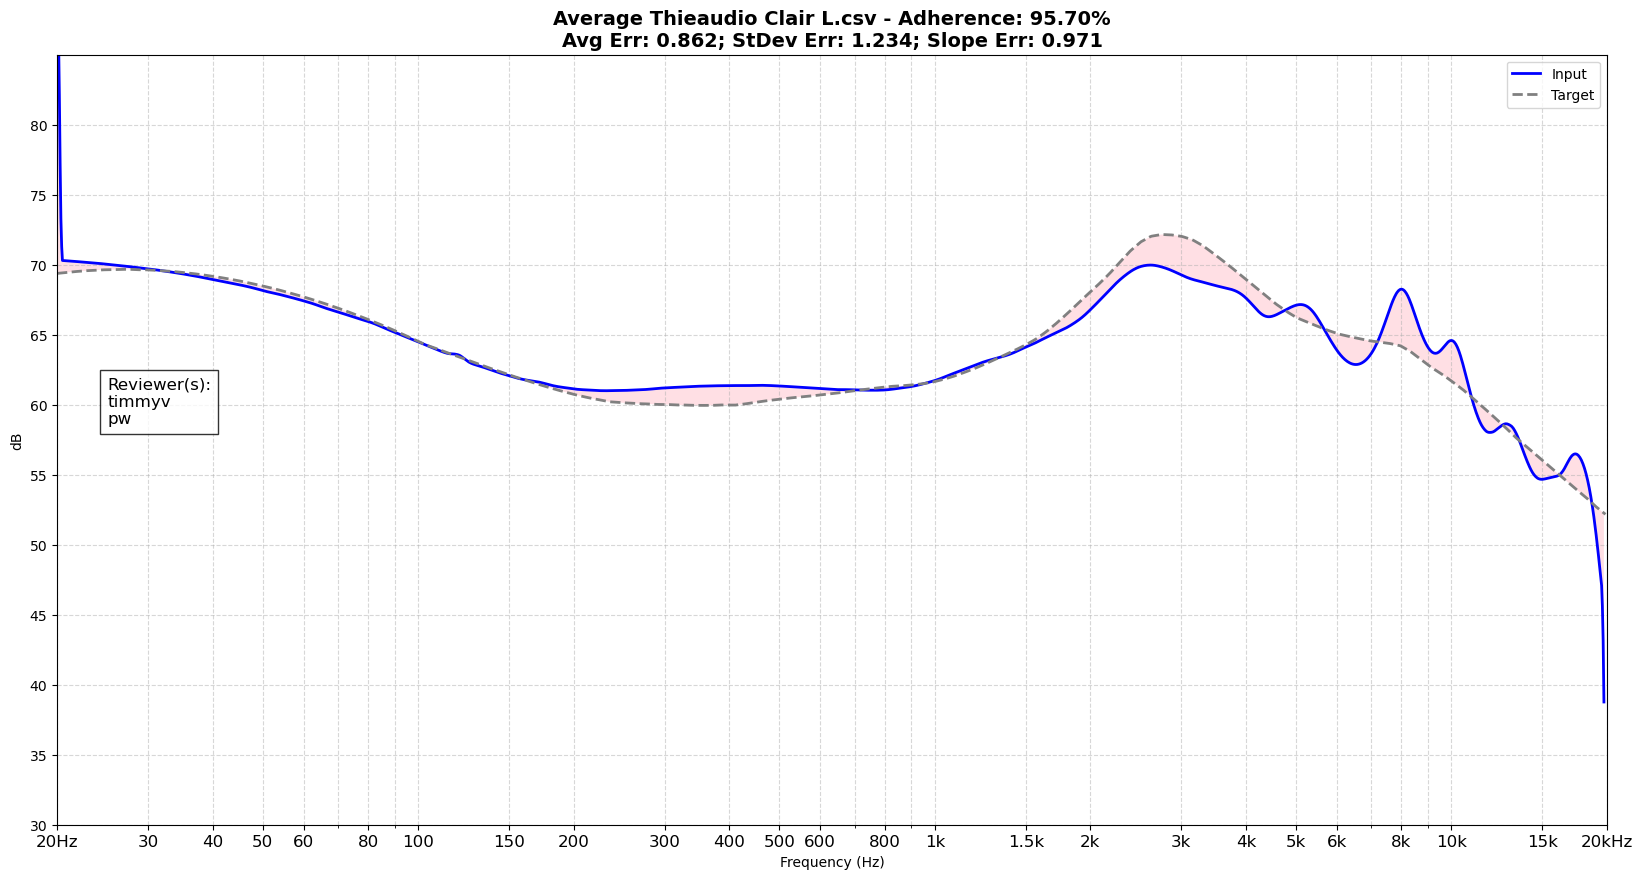

Plotting Resolve Pixel Buds Pro Gras L.csv with Preference %: 95.62%


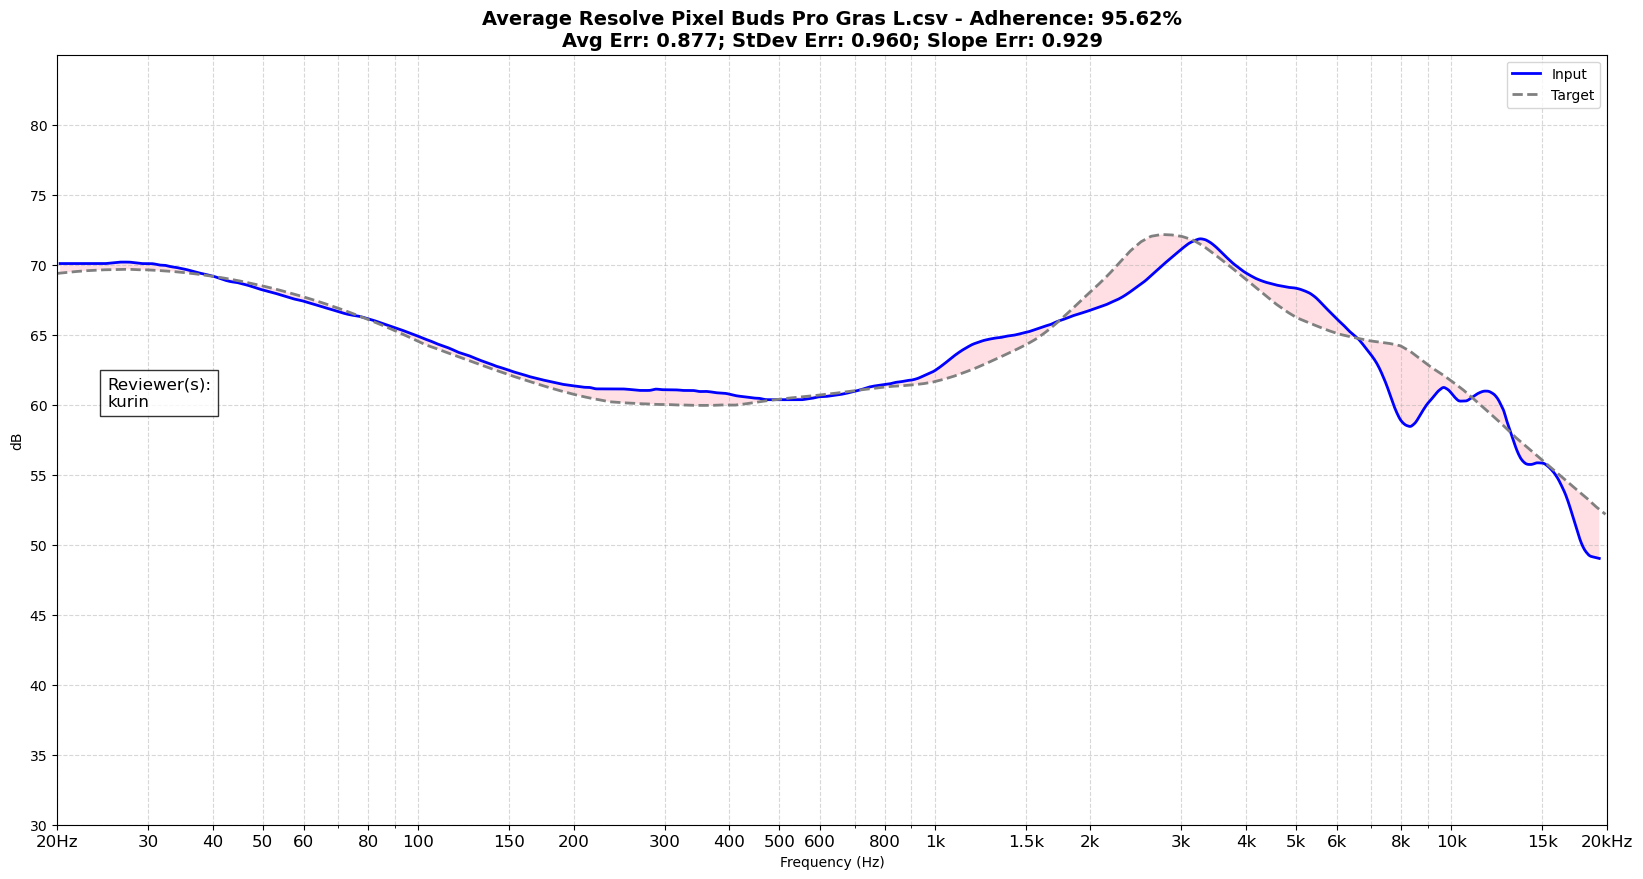

Plotting Broken Variations.csv with Preference %: 95.62%


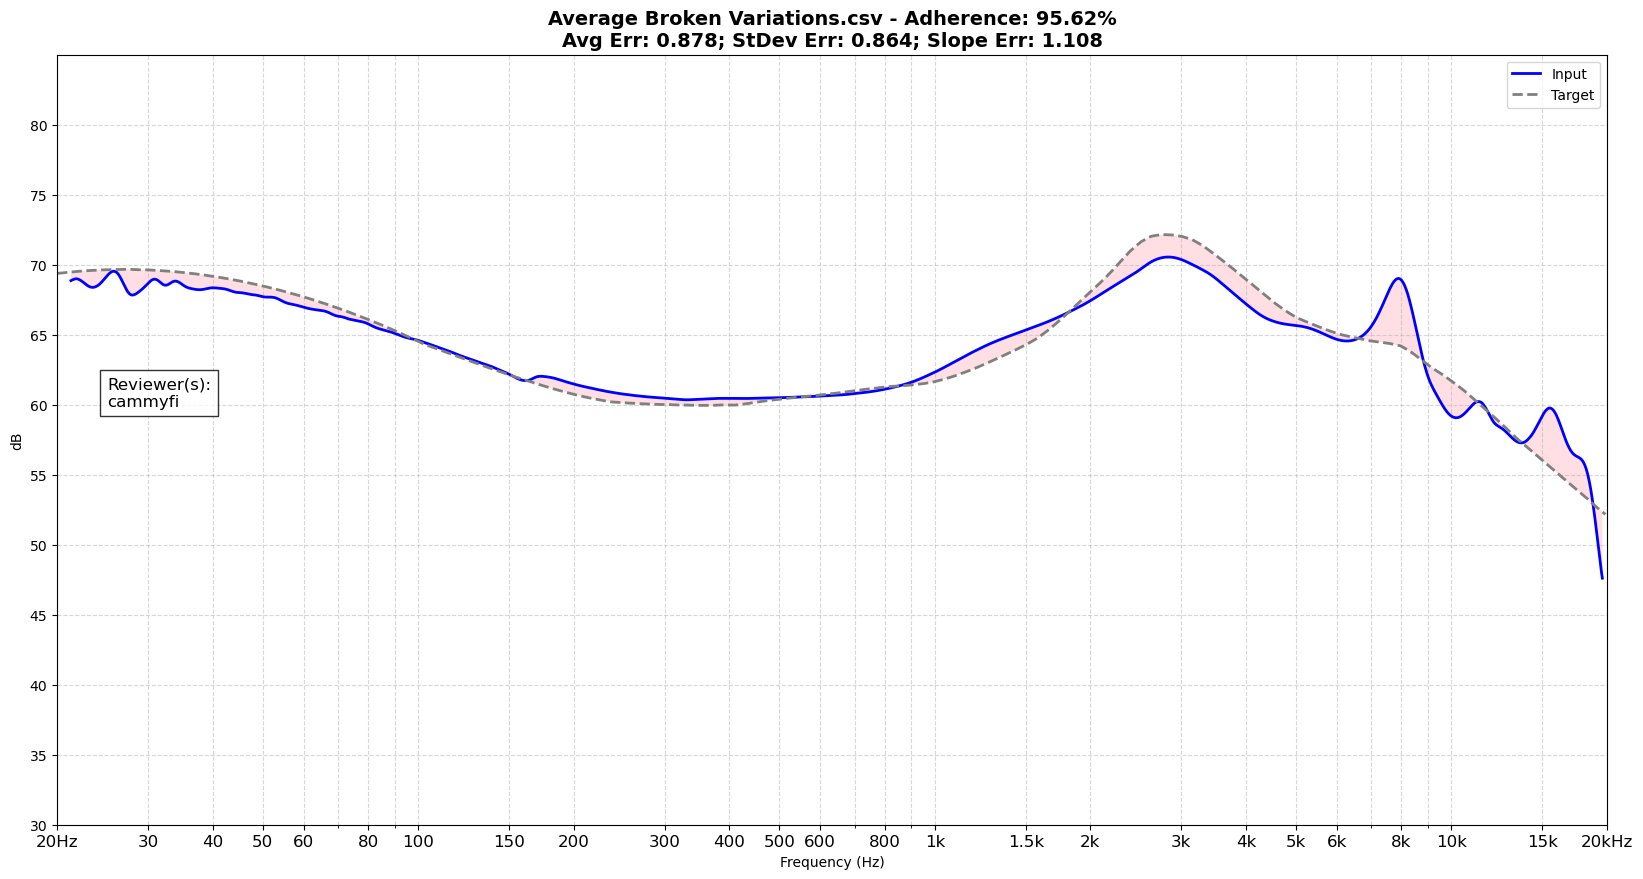

Plotting THIEAUDIO MONARCH MKII L.csv with Preference %: 95.40%


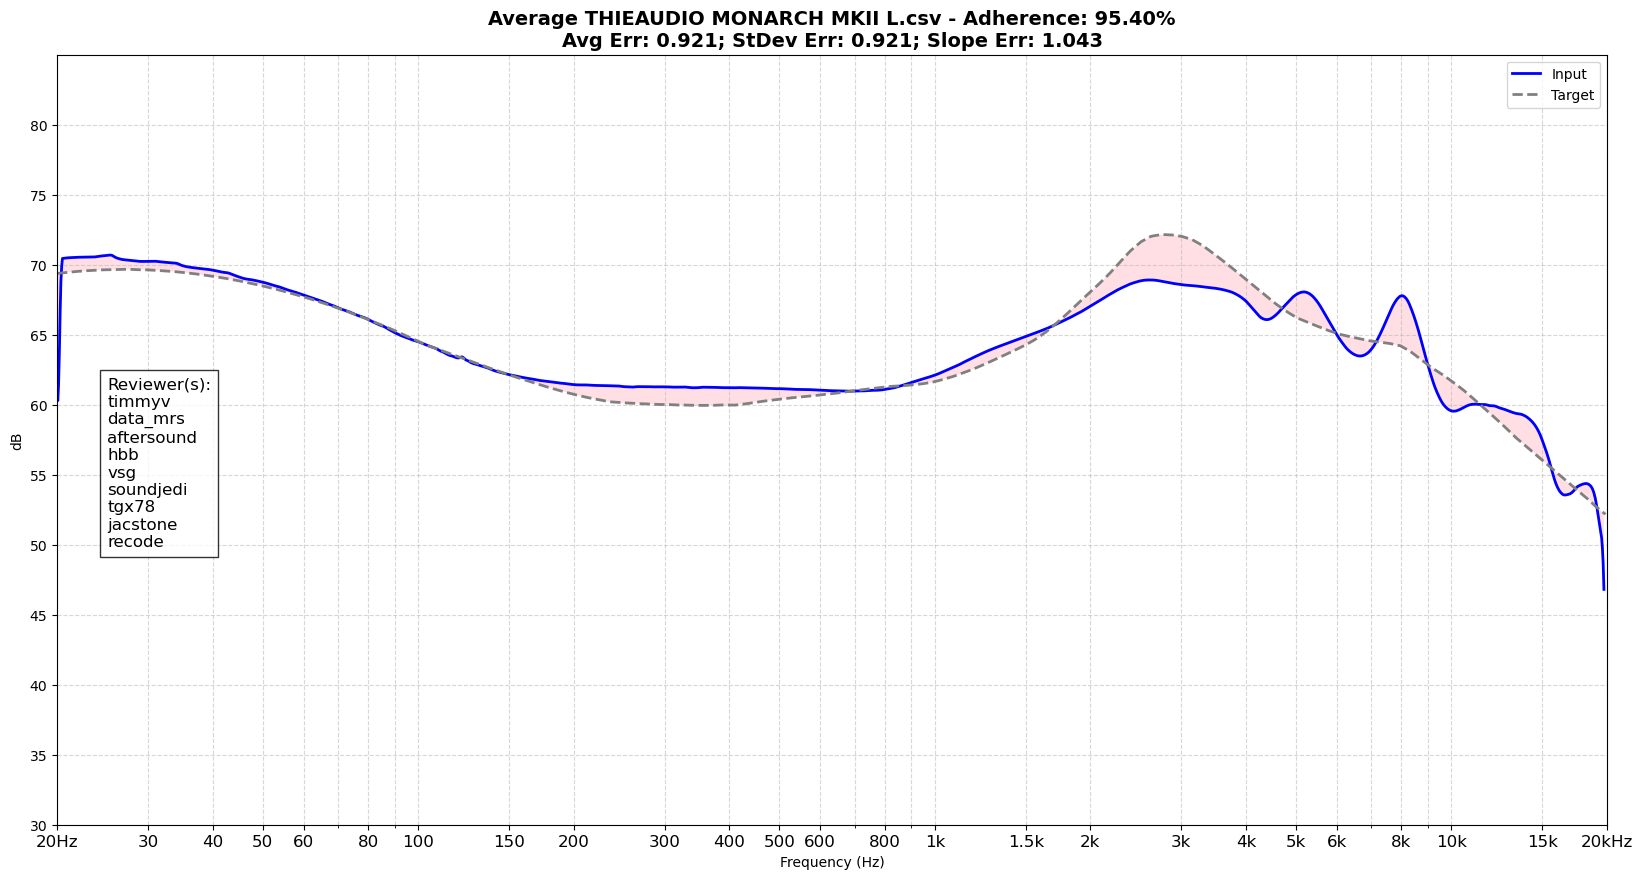

Plotting Resolve Galaxy Buds2 Pro Active Anc Gras L.csv with Preference %: 95.11%


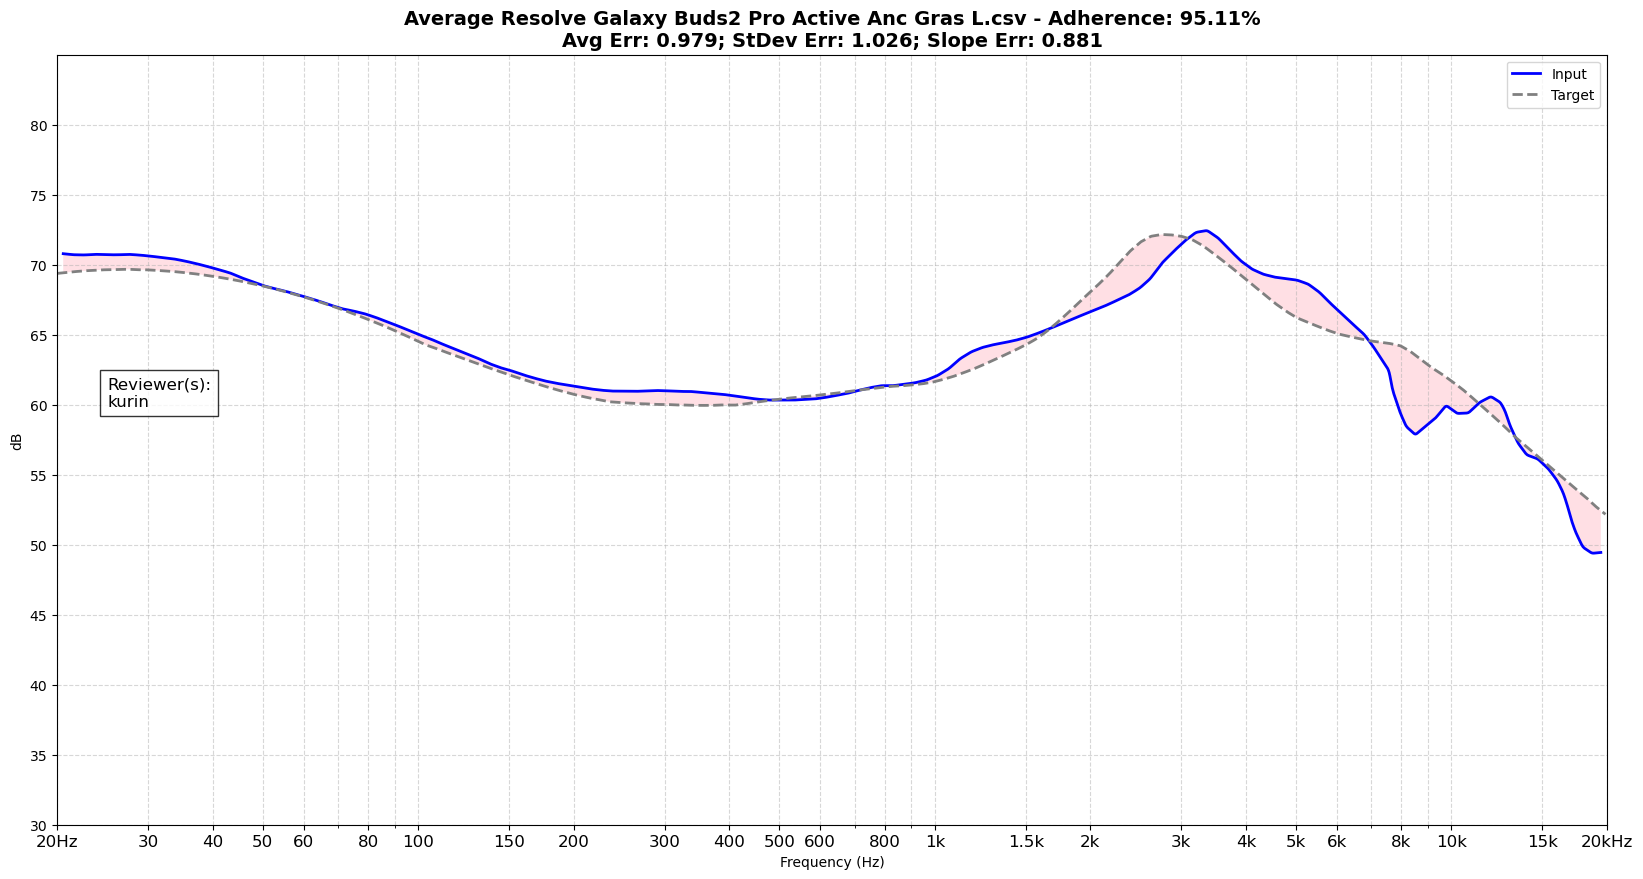

Plotting LETSHUOER Conductor 75ohm L.csv with Preference %: 95.04%


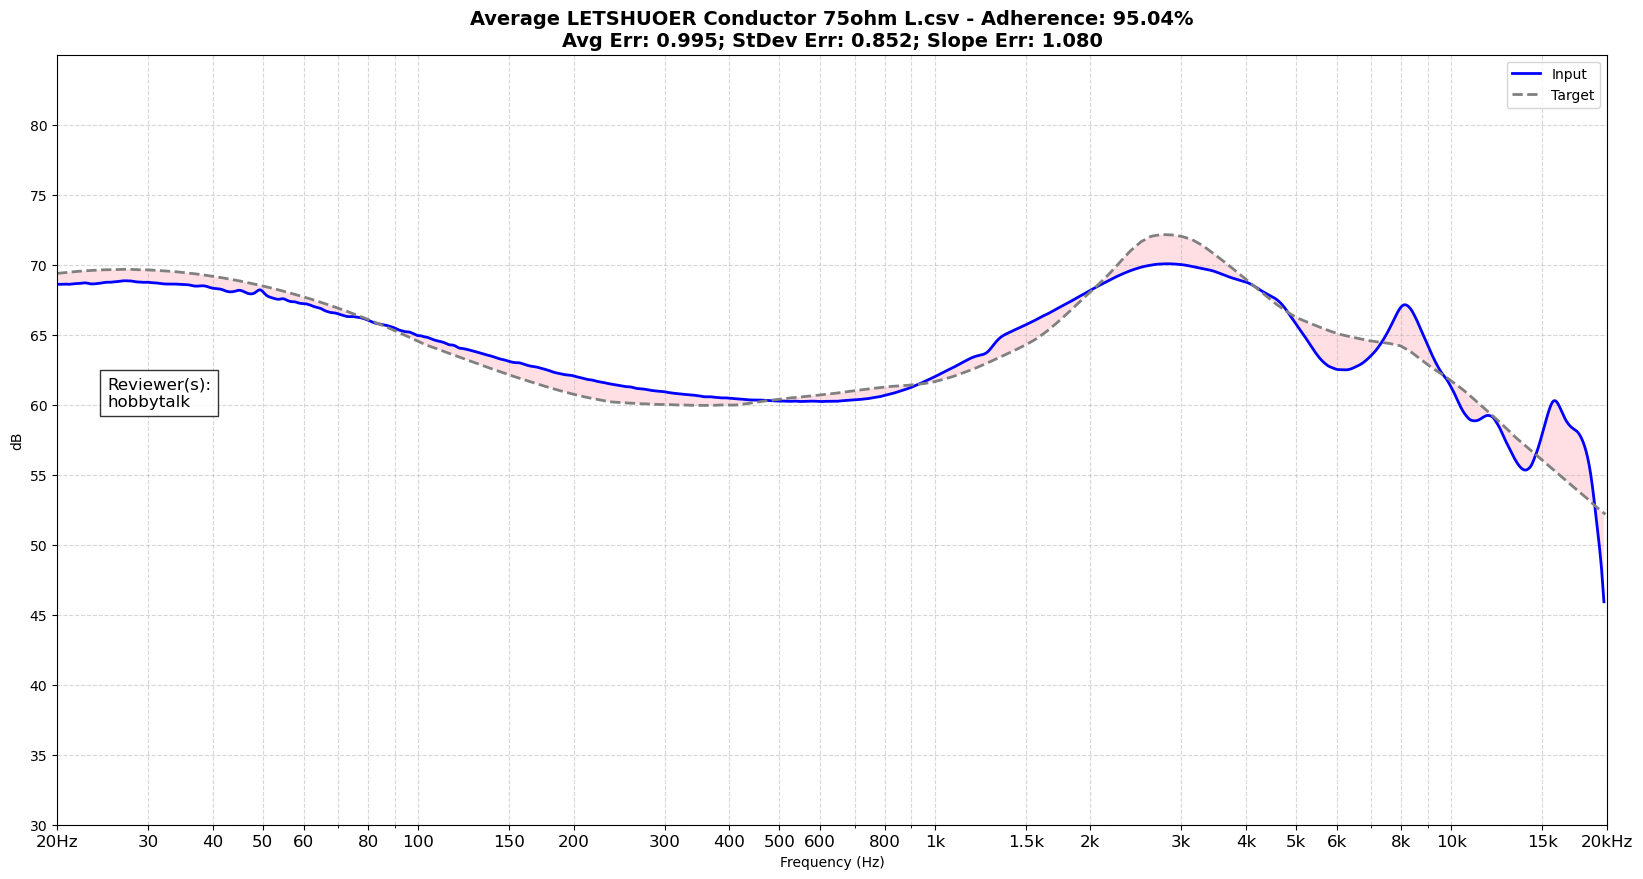

Plotting KZ D-FI DDUD R.csv with Preference %: 94.95%


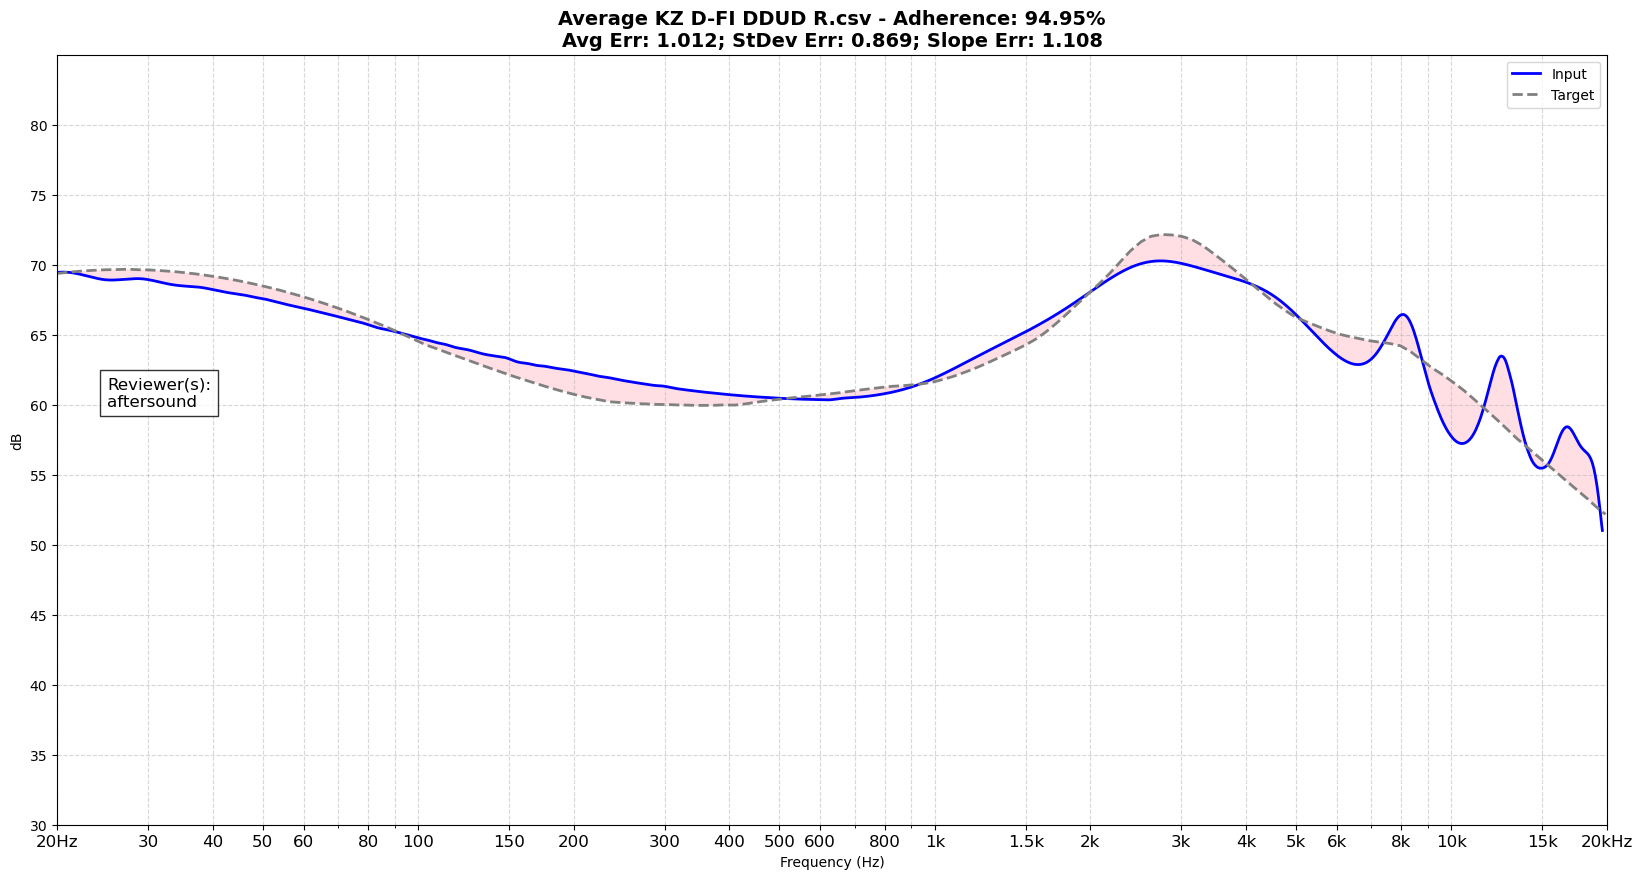

Plotting Average Reviewer.csv with Preference %: 94.91%


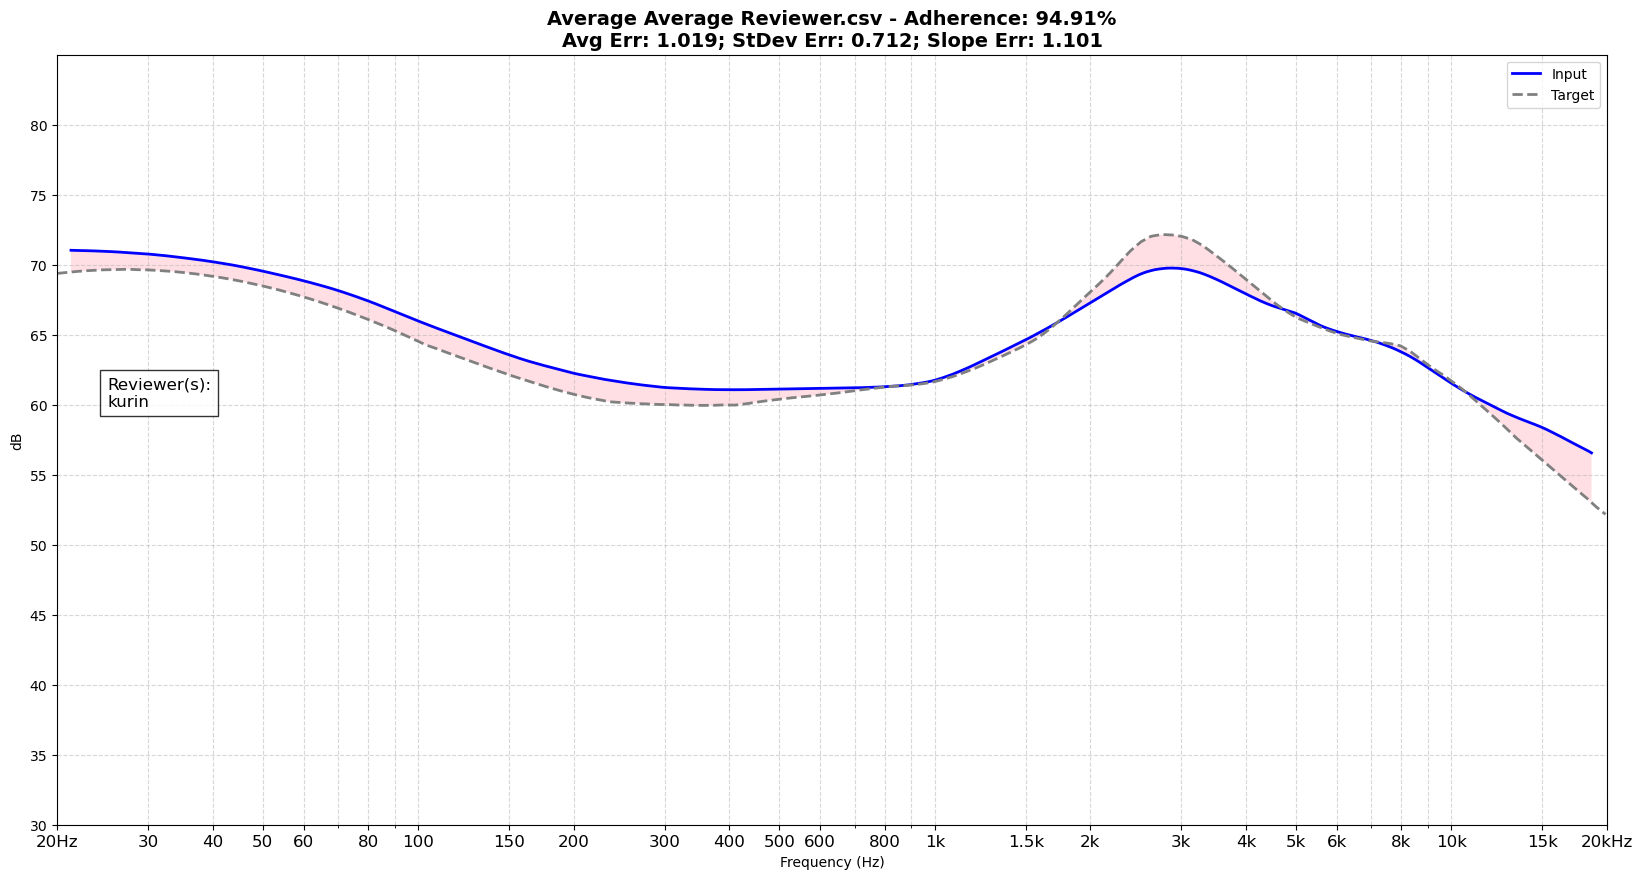

Plotting Letshuoer KL L.csv with Preference %: 94.71%


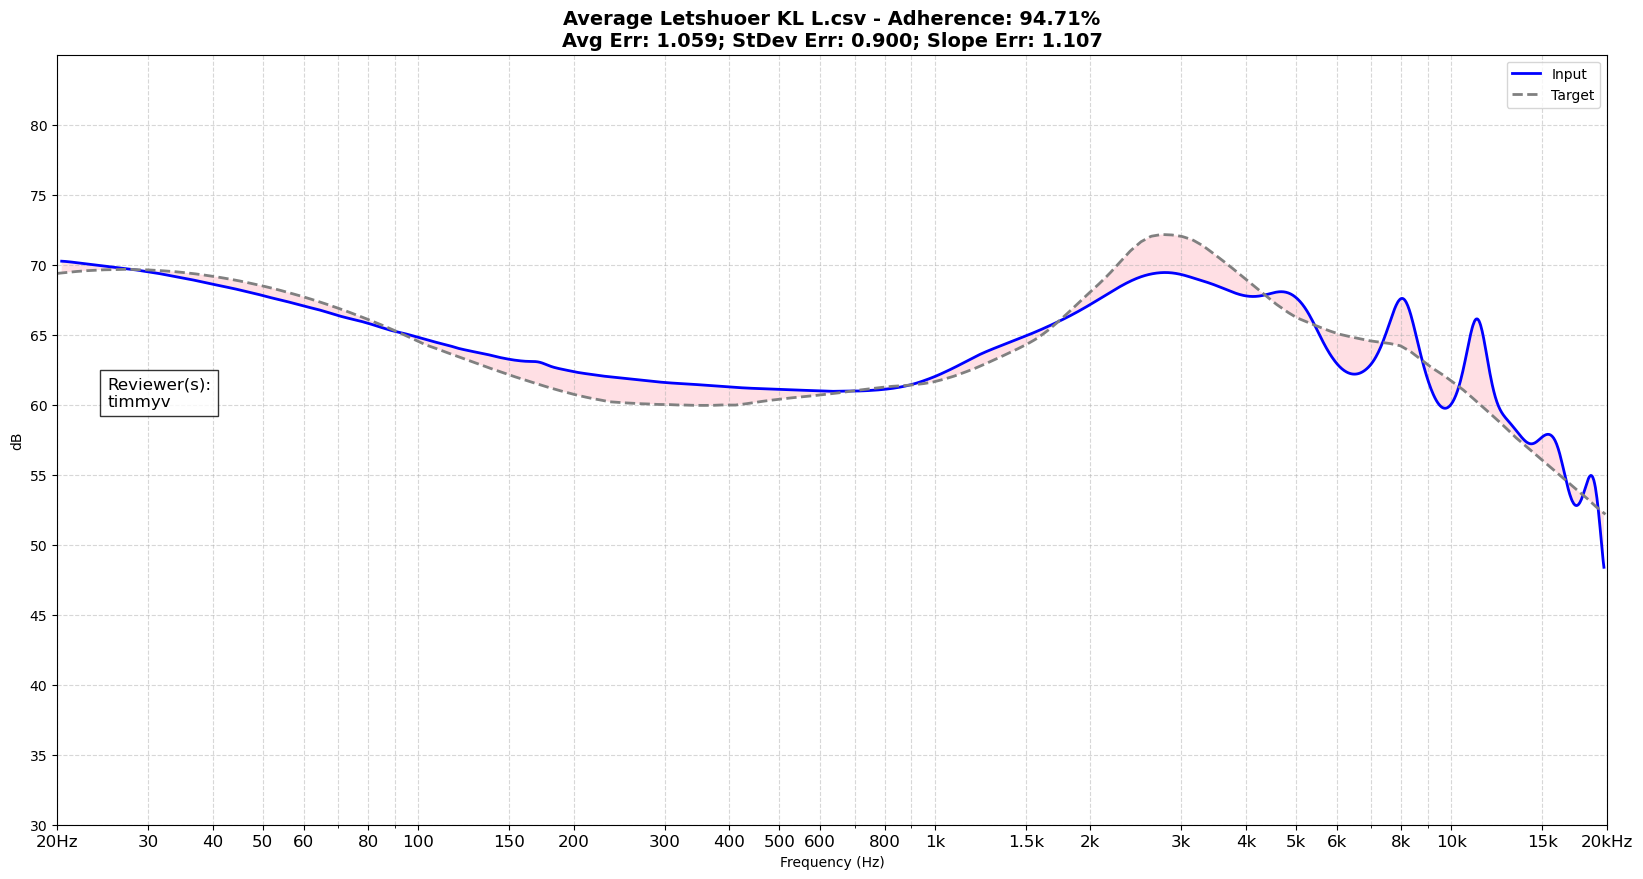

Plotting Variations_sb2 L.csv with Preference %: 94.56%


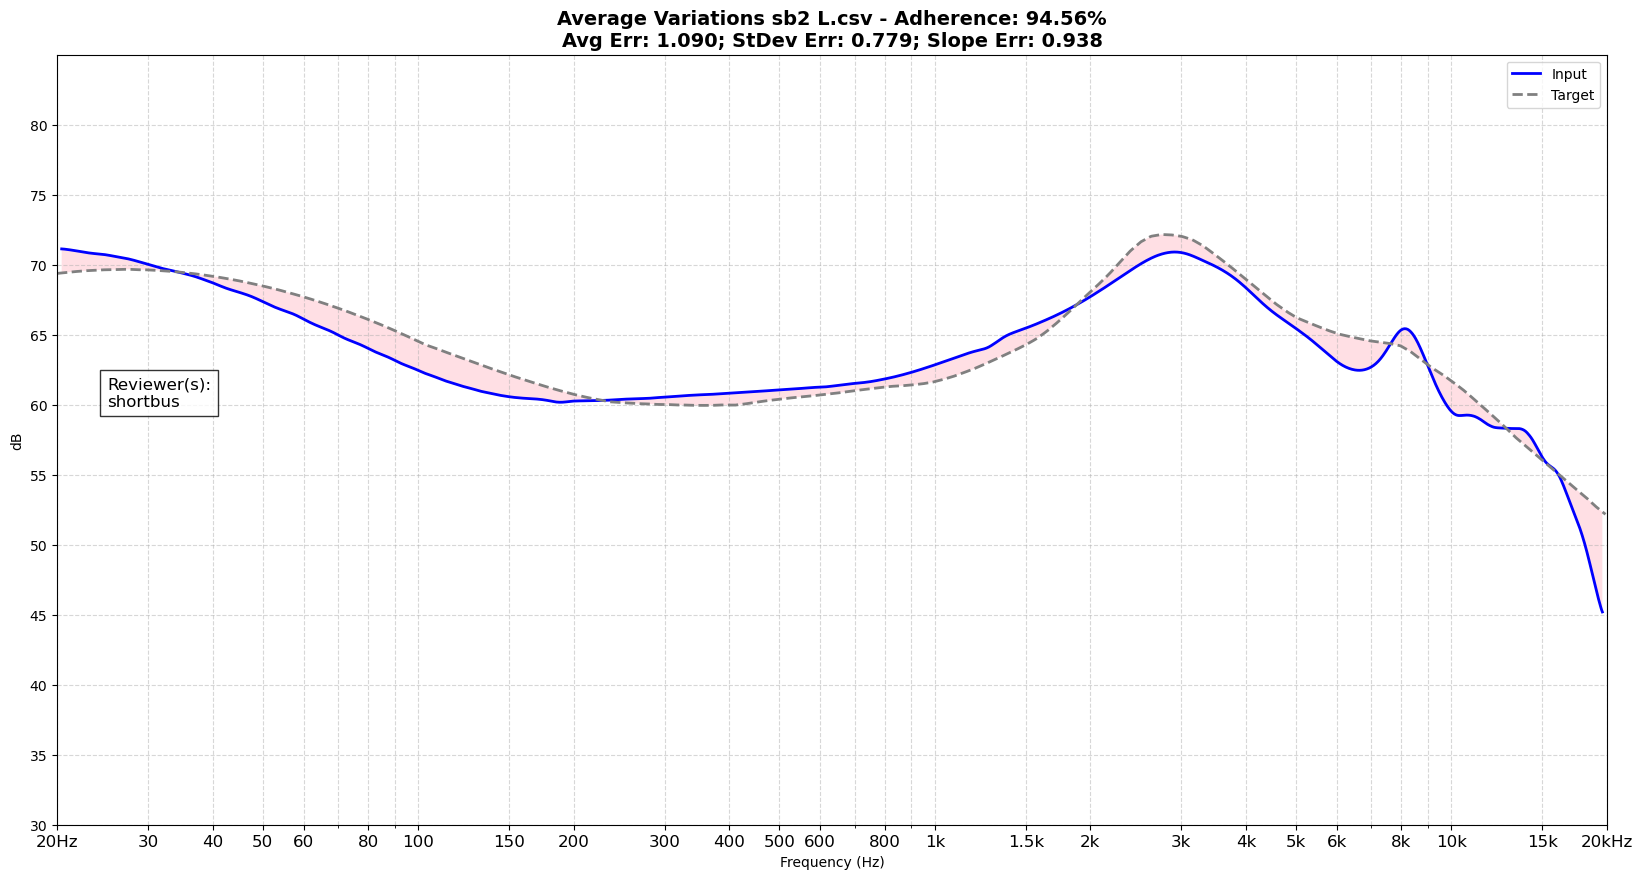

Plotting MOONDROP VARIATIONS L.csv with Preference %: 94.56%


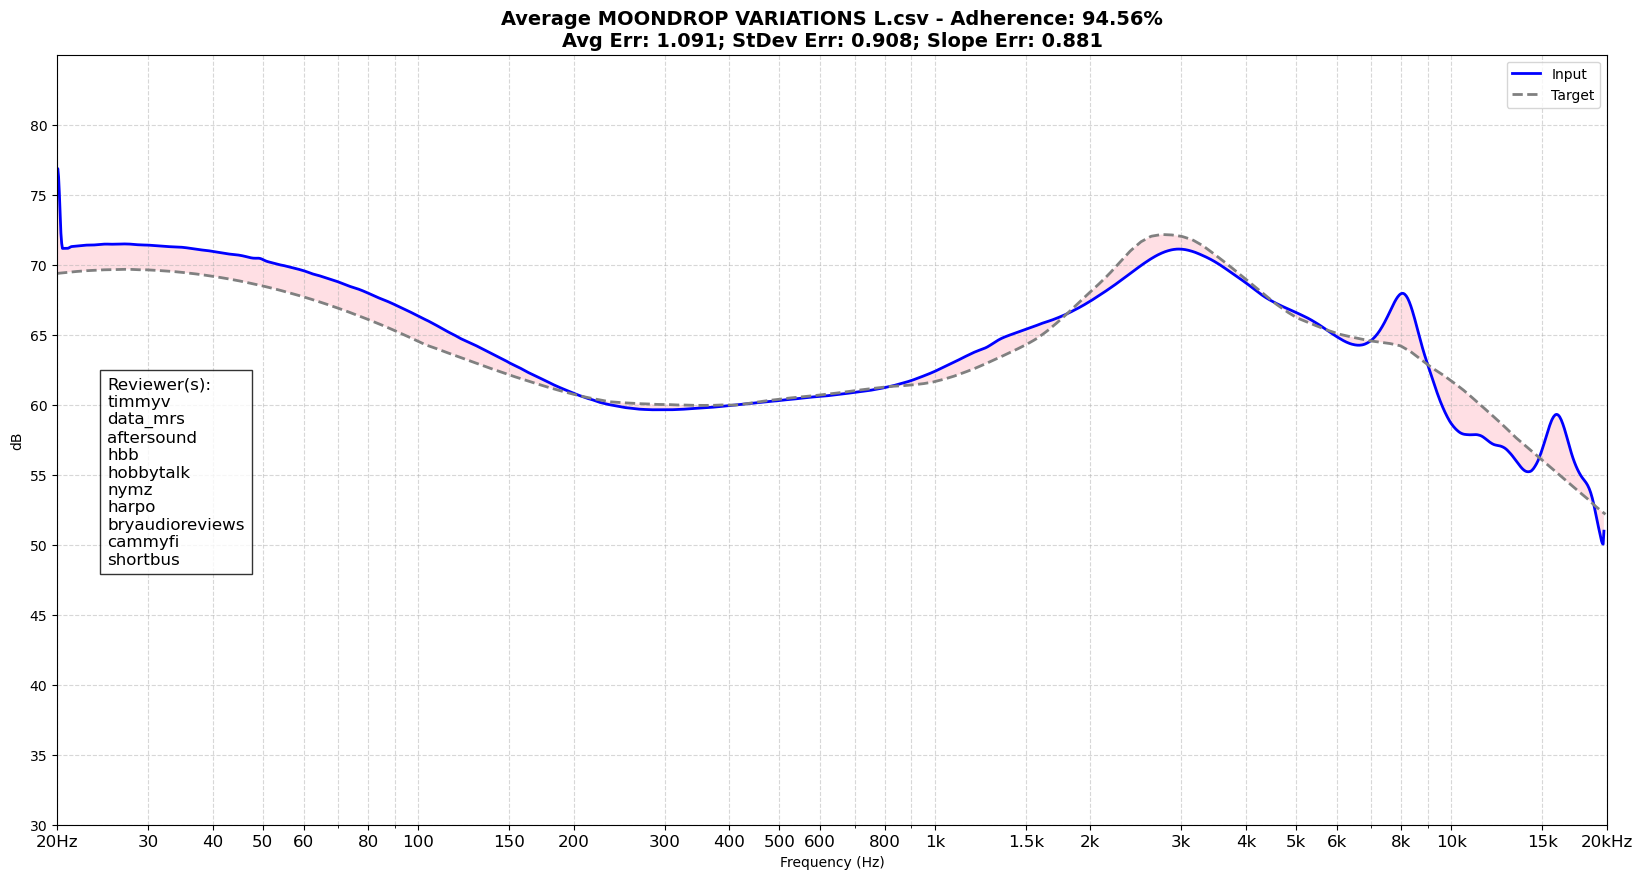

Plotting AKG N5005 (BASS) L.csv with Preference %: 94.54%


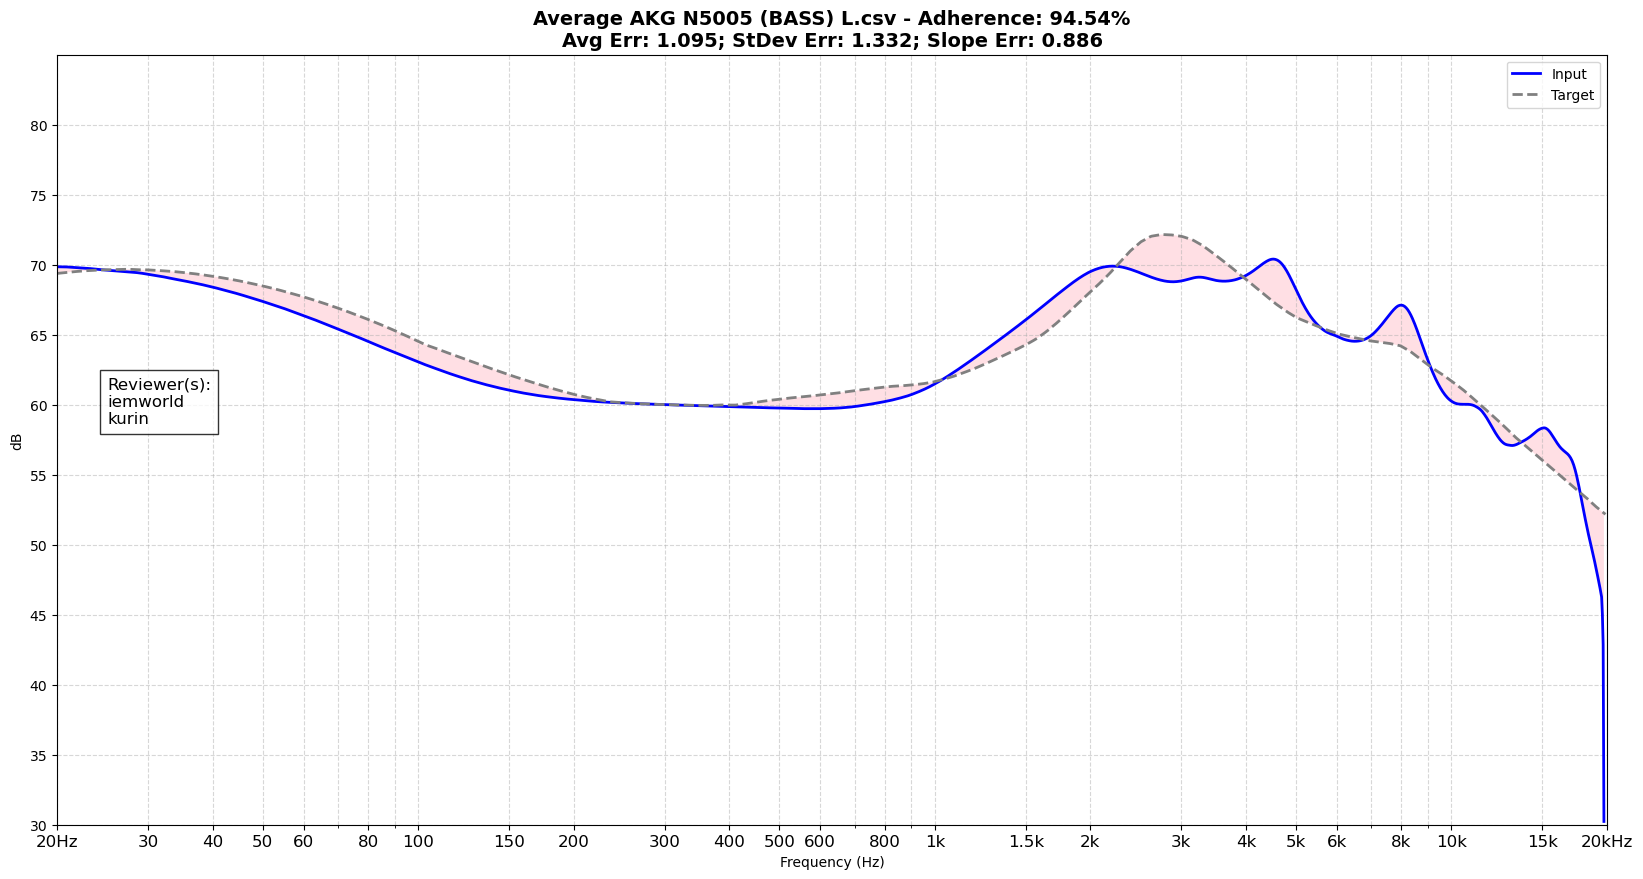

Plotting FF GM 2 R.csv with Preference %: 94.46%


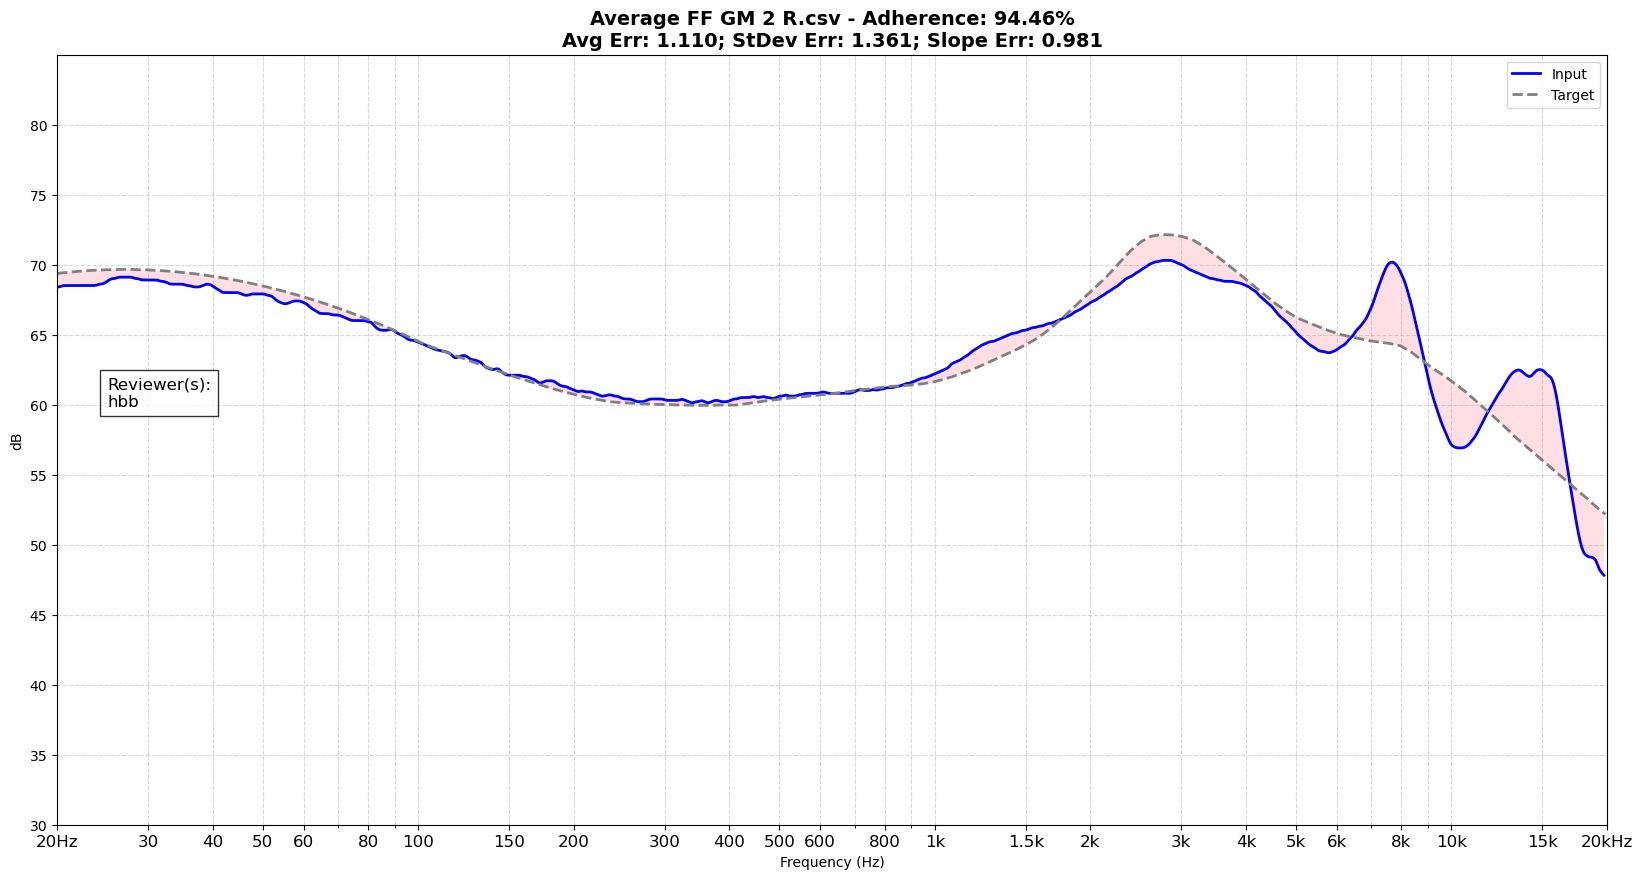

Plotting Truthear Zero L.csv with Preference %: 94.43%


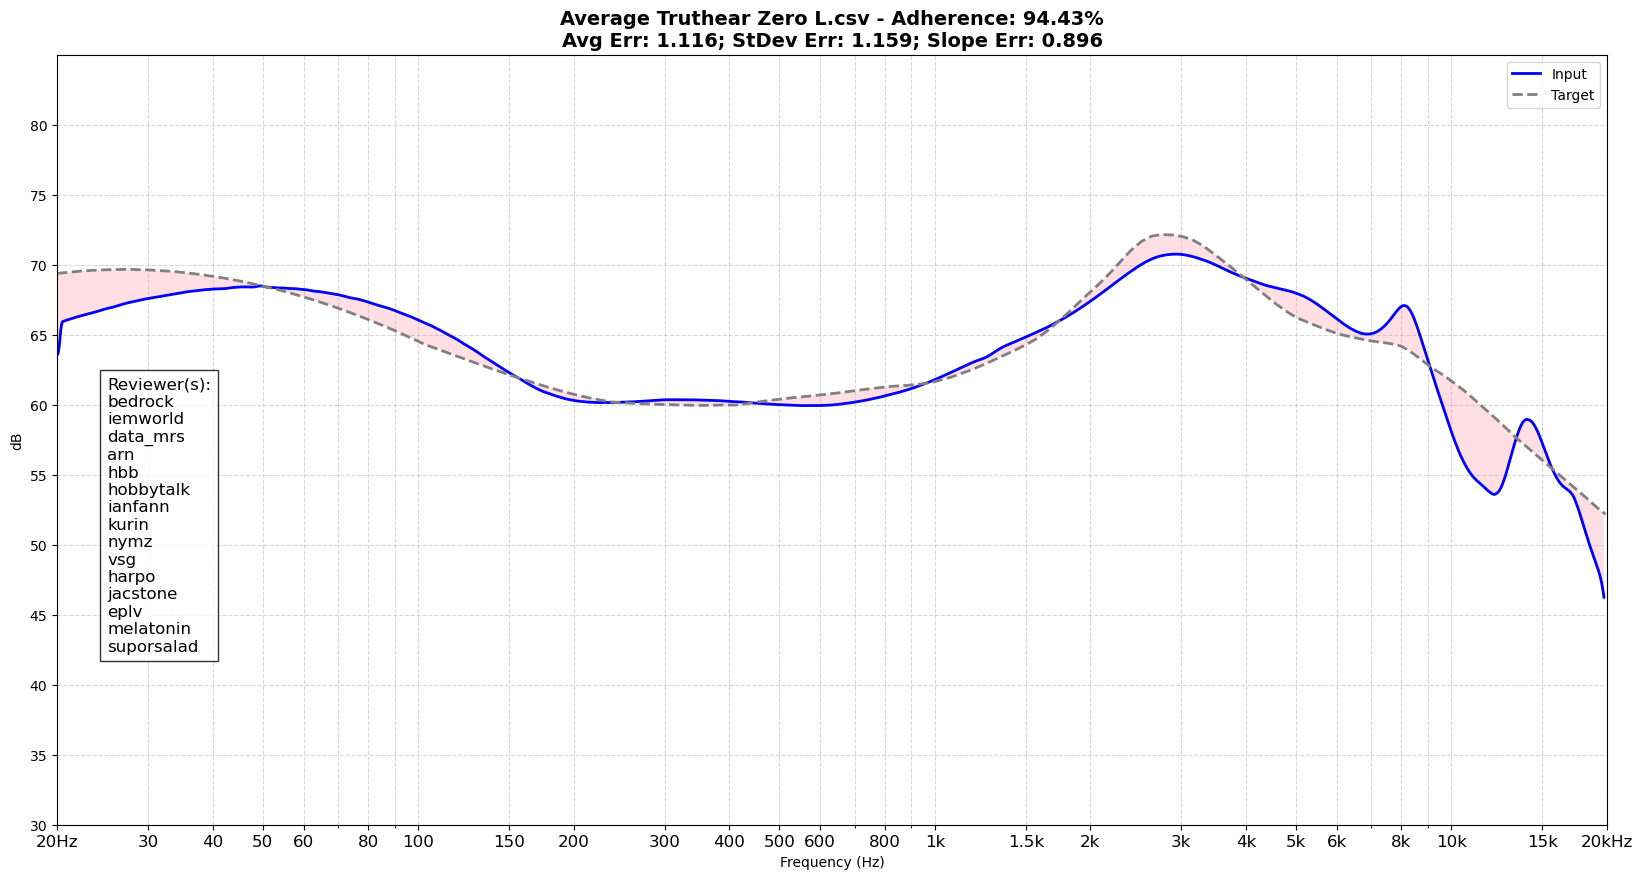

In [172]:
import matplotlib.pyplot as plt

# Sort avg_df by 'Preference %' in descending order and exclude IEMs with a preference of 100%
top_10 = avg_df[avg_df['Preference %'] < 100].sort_values(by='Preference %', ascending=False).head(15)

# Iterate through the top 10 rows and create a plot for each
for idx, row in top_10.iterrows():
    iem_name = row['IEM']
    input_csv = row['Average Measurement']
    adherence_percentage = row['Preference %']
    reviewers = row['Reviewers']
    avg_error = row['Average Error']
    stdev_error = row['STDEV of Error']
    slope_error = row['Slope of Error']
    print(f"Plotting {iem_name} with Preference %: {adherence_percentage:.2f}%")
    # You can change the colors parameter to the color you'd like to use for the input data line
    plot_preference(input_csv, target_csv, adherence_percentage, colors='blue', reviewers=reviewers, avg_error=avg_error, stdev_error=stdev_error, slope_error=slope_error)
